# Import Libraries


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout


# Helper Function

In [2]:
# Define the function to create the LSTM model
def create_model(n_steps, n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(n_features, activation='linear'))
    model.compile(optimizer='adam', loss='mse')

    return model

# Define the function to generate the input and output sequences for the LSTM model

# This function only use to compare the predicted value with the real value within a specific of time
def generate_sequences_single_step(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps, :])
        y.append(data[i+n_steps, :])
    X, y = np.array(X), np.array(y)
    
    return X, y

# Dataset

In [3]:
dataset = pd.read_csv('6_hours_IoTPond1.csv', index_col=0, parse_dates=True)

<Figure size 2000x2000 with 0 Axes>

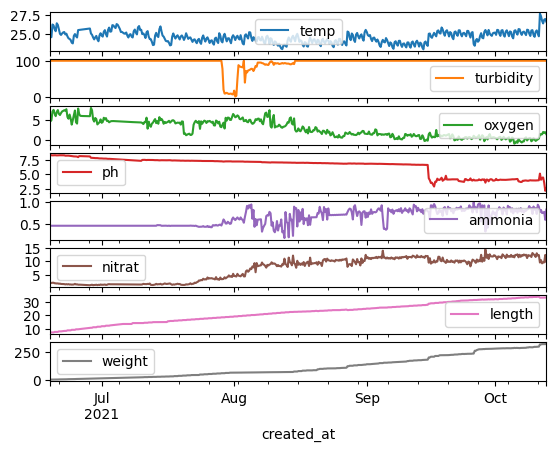

In [4]:
plt.figure(figsize=(20, 20))
dataset.plot(subplots=True)
plt.show()

## Preparation (Single-step)

In [5]:
# Define the number of time steps to forecast
n_steps = 4

# Define the number of features in the dataset
n_features = dataset.shape[1]

# Split the dataset into training and testing sets
train_size = int(len(dataset) * 0.8)
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [6]:
# Scale the data using a MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [7]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

# Generate the input and output sequences for the training and testing sets
X_train, y_train = generate_sequences_single_step(train_scaled, n_steps)
X_test, y_test = generate_sequences_single_step(test_scaled, n_steps)

## Data Pipelines

In [8]:
# Proprocess the dataset using built-in dataset library from Tensorflow
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_data = val_data.batch(BATCH_SIZE)

# Training Phase

In [9]:
# Create the LSTM model
model = create_model(n_steps, n_features)

# Train the model
model.fit(train_data, epochs=100, batch_size=32, validation_data=val_data, verbose=1)


Epoch 1/100
12/12 [==============================] - 7s 93ms/step - loss: 0.3494 - val_loss: 0.5383
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1669 - val_loss: 0.2907
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0691 - val_loss: 0.1487
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0518 - val_loss: 0.1043
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0360 - val_loss: 0.0867
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0285 - val_loss: 0.0751
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0250 - val_loss: 0.0720
Epoch 8/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0253 - val_loss: 0.0651
Epoch 9/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0232 - val_loss: 0.0601
Epoch 10/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0224 - val_loss: 0.0545

In [10]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.01235065795481205


# Predicting 

In [11]:
test_pond_2 = pd.read_csv('6_hours_IoTPond2.csv', index_col=0, parse_dates=True)
test_X = scaler.transform(test_pond_2.iloc[:, :])

In [12]:
test_X, test_Y = generate_sequences_single_step(test_X, n_steps)

In [13]:
test_data = tf.data.Dataset.from_tensor_slices((test_X, test_Y))
test_data = test_data.batch(BATCH_SIZE)

In [14]:
y_pred = model.predict(test_data)
y_pred_scaled = scaler.inverse_transform(y_pred)

1/1 [==============================] - 0s 419ms/step


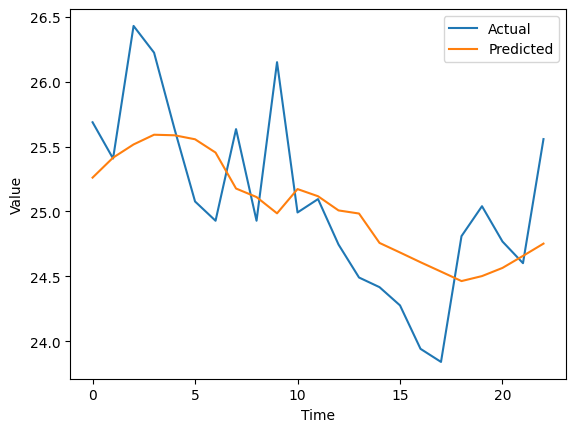

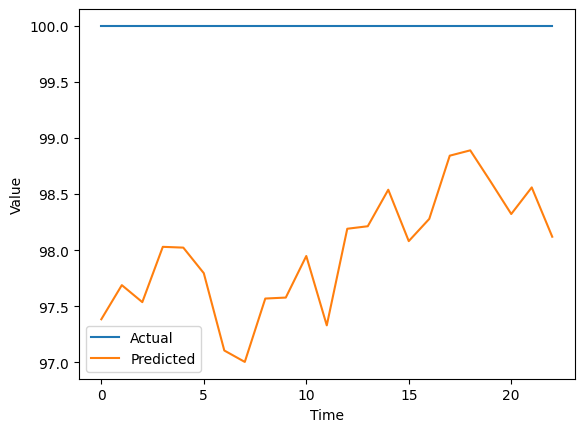

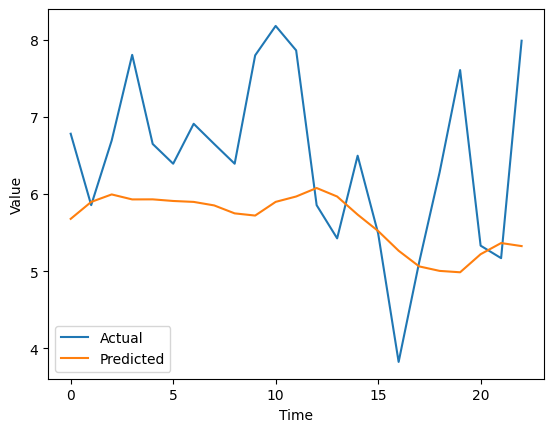

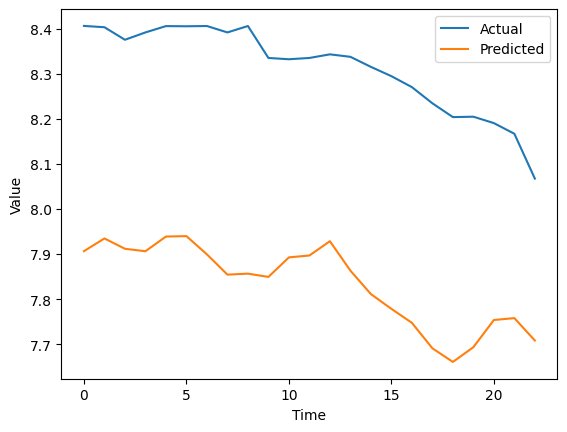

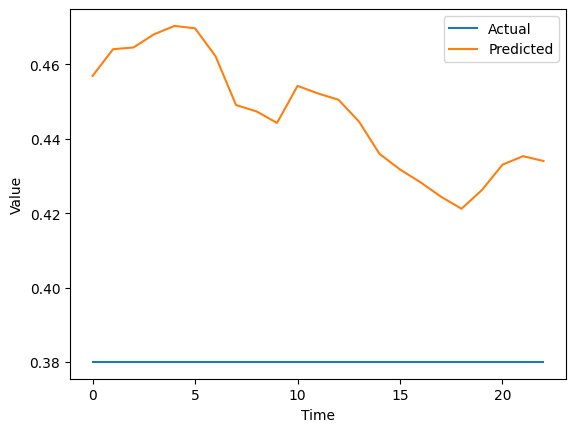

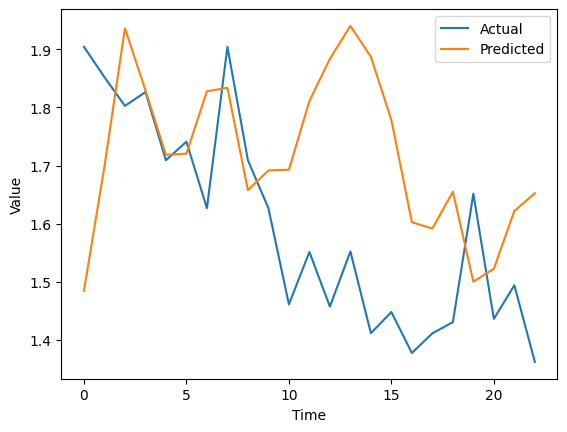

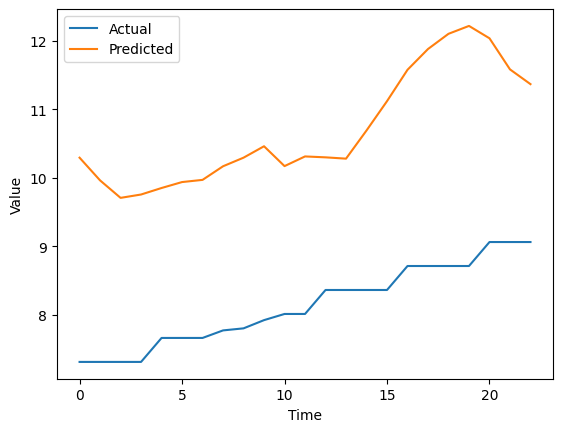

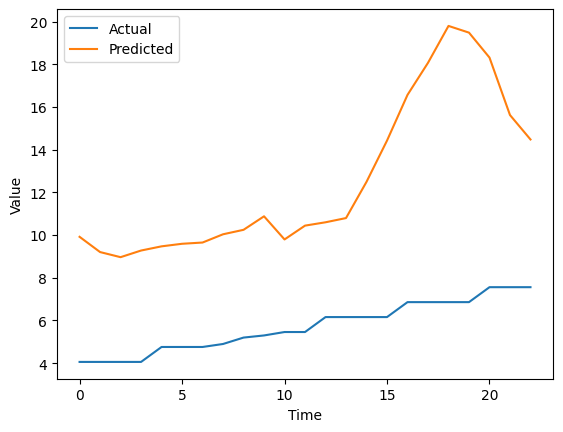

In [15]:
for i in range(len(test_pond_2.columns)):
    # Plot the predicted values against the actual values
    plt.plot(test_pond_2.iloc[n_steps:, i].values, label='Actual')
    plt.plot(y_pred_scaled[:, i], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
# plt.xticks(rotation=45, ha='right')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

In [16]:
!mkdir -p /content/sample_model

In [17]:
!rm -r /content/sample_model

In [18]:
# save_model(model, '/content/sample_model', overwrite=True, include_optimizer=True, save_format=None)

model.save('sample_model.h5')
# tf.saved_model.simple_save(model, '/content/sample_model', overwrite=True, include_optimizer=True, inputs={'input_image': model.input}, outputs={t.name: t for t in model.outputs})
# !rm -r /content/sample_model

In [19]:
# sample_model = zipfile.ZipFile('sample_model.zip', 'w')
# sample_model.write('/content/sample_model/', arcname='sample_model')
# sample_model.close()

!zip -r 'sample_model.zip' 'sample_model'

	zip warning: name not matched: sample_model

zip error: Nothing to do! (try: zip -r sample_model.zip . -i sample_model)
